# Kalman filter

Notebook about testing bootstrap pf and auxiliary pf on simpler model for which kalman filter exits.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [46]:
from src.models.lgm import LGModelParams, LGModel
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.auxiliary_pf import AuxiliaryParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data
from src.filters.kalman.kalman_filter import KalmanFilter

In [47]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=0.6,
    sigma_y=0.8
)

model = LGModel(rng=rng)

In [48]:
# Generate data
T = 100

x_true, y = simulate_data(model, theta, T, rng)

In [49]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [50]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)
apf = AuxiliaryParticleFilter(model, N, resampler=systematic_resampling)
bpf_history = bpf.run(y, theta)
apf_history = apf.run(y, theta)

In [51]:
print(len(bpf_history))

101


In [52]:
def compute_pf_stats(history):
    means, vars_ = [], []
    for i in range(len(history)):
        particles, weights, _, _ = history[i]
        particles = np.array(particles.x_t)
        mean = np.sum(weights * particles)
        var = np.sum(weights * (particles - mean)**2)
        means.append(mean)
        vars_.append(var)
    return np.array(means), np.array(vars_)

In [53]:
bpf_mean, bpf_var = compute_pf_stats(bpf_history)
apf_mean, apf_var = compute_pf_stats(apf_history)

In [54]:
print(bpf_mean.shape)
print(apf_mean.shape)

(101,)
(101,)


In [55]:
kf = KalmanFilter()
kf_mean, kf_var = kf.filter(y, theta)

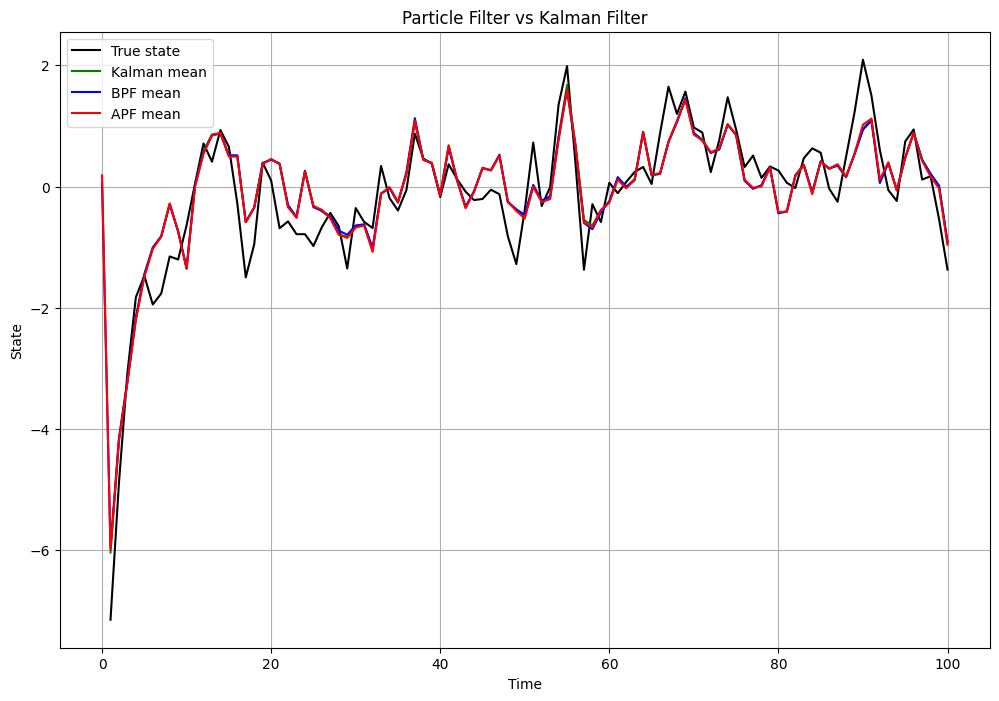

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True state", color='black')                    # Data starts at time step 1, so we plot from 1 to T
plt.plot(np.arange(1, len(kf_mean)+1), kf_mean, label="Kalman mean", linestyle='-', color='green')  # Same here, kf_mean is defined from time step 1 to T
plt.plot(np.arange(0, len(bpf_mean)), bpf_mean, label="BPF mean", linestyle='-', color='blue')      # For particle filters, we have estimates at t=0 (the prior)
plt.plot(np.arange(0, len(apf_mean)), apf_mean, label="APF mean", linestyle='-', color='red')       # Same here
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Particle Filter vs Kalman Filter")
plt.legend()
plt.grid()
plt.show()

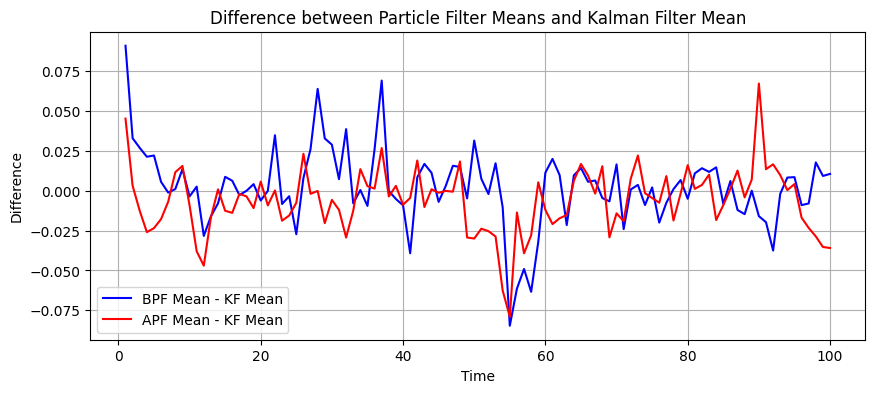

In [57]:
# Plot difference between PF means and KF mean
plt.figure(figsize=(10,4))
plt.plot(np.arange(1, len(kf_mean)+1), bpf_mean[1:] - kf_mean, label="BPF Mean - KF Mean", color='blue')   # Again, data starts at time step 1
plt.plot(np.arange(1, len(kf_mean)+1), apf_mean[1:] - kf_mean, label="APF Mean - KF Mean", color='red')
plt.xlabel("Time")
plt.ylabel("Difference")
plt.title("Difference between Particle Filter Means and Kalman Filter Mean")
plt.legend()
plt.grid()
plt.show()

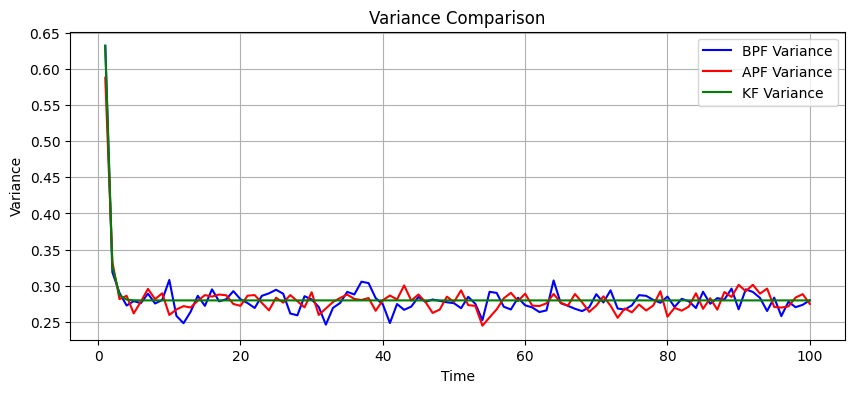

In [58]:
# Plot variances
plt.figure(figsize=(10,4))
plt.plot(np.arange(1, len(bpf_var)), bpf_var[1:], label="BPF Variance", color='blue')   # For pf we also have prior variance at t=0, 
                                                                                        # but we plot from 1 to T because it is meaningless 
                                                                                        # to plot it at t=0 if we cant compare
plt.plot(np.arange(1, len(apf_var)), apf_var[1:], label="APF Variance", color='red')    # Same here, we plot from 1 to T
plt.plot(np.arange(1, len(kf_var)+1), kf_var, label="KF Variance", color='green')
plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Variance Comparison")
plt.legend()
plt.grid()
plt.show()

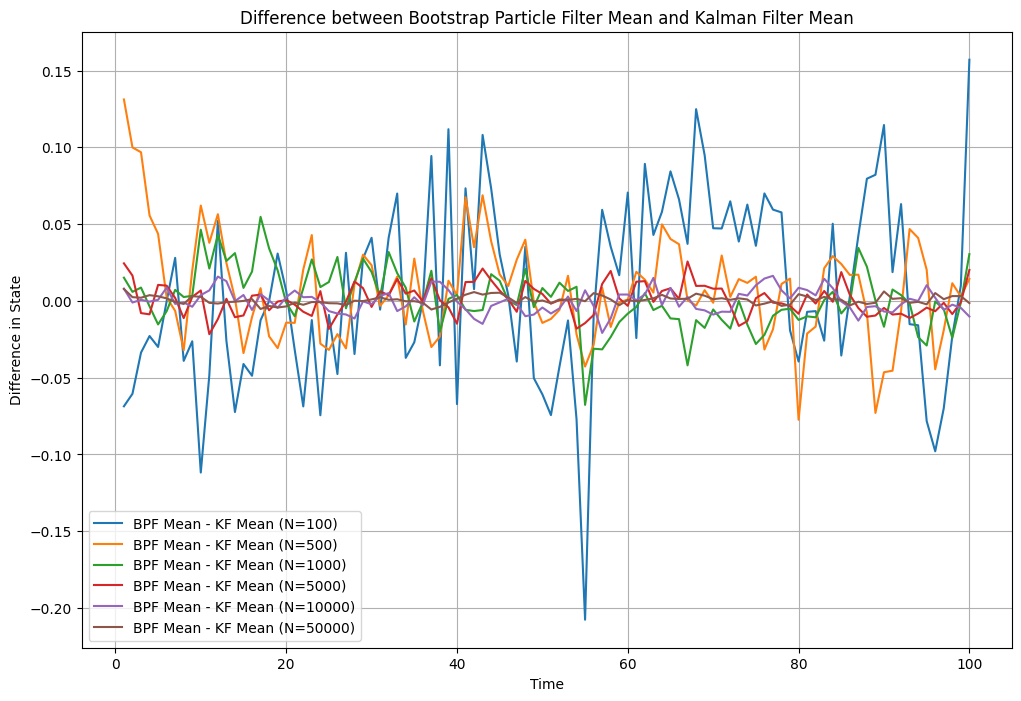

In [59]:
# Compare bootstrap pf for different number of particles
Ns = [100, 500, 1000, 5000, 10000, 50000]

# Plot BPF difference to kalman filter for different N
plt.figure(figsize=(12, 8))
for N in Ns:
    bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)
    bpf_history = bpf.run(y, theta)
    bpf_mean, bpf_var = compute_pf_stats(bpf_history)

    plt.plot(np.arange(1, len(kf_mean)+1), bpf_mean[1:] - kf_mean, label=f"BPF Mean - KF Mean (N={N})")    # Again, we only plot differences from t=1 onwards
    
plt.xlabel("Time")
plt.ylabel("Difference in State")
plt.title("Difference between Bootstrap Particle Filter Mean and Kalman Filter Mean")
plt.legend()
plt.grid()
plt.show()

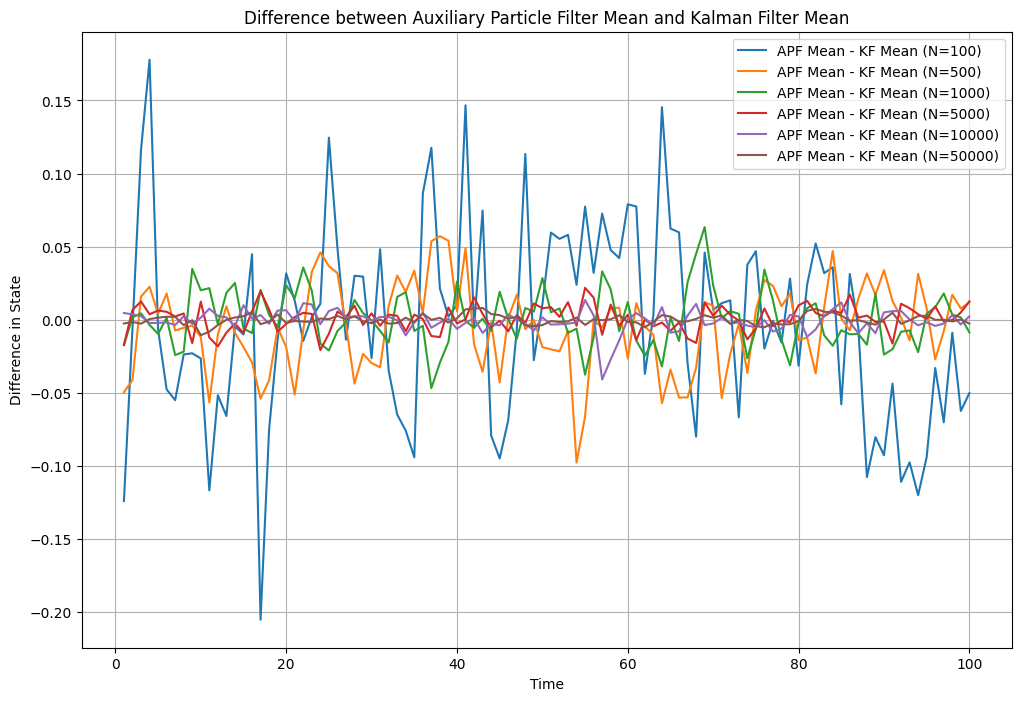

In [60]:
# Same for APF
plt.figure(figsize=(12, 8))
for N in Ns:
    apf = AuxiliaryParticleFilter(model, N, resampler=systematic_resampling)
    apf_history = apf.run(y, theta)
    apf_mean, apf_var = compute_pf_stats(apf_history)

    plt.plot(np.arange(1, len(kf_mean)+1), apf_mean[1:] - kf_mean, label=f"APF Mean - KF Mean (N={N})")    # Again, we only plot differences from t=1 onwards
    
plt.xlabel("Time")
plt.ylabel("Difference in State")
plt.title("Difference between Auxiliary Particle Filter Mean and Kalman Filter Mean")
plt.legend()
plt.grid()
plt.show()